# Open-Loop Evaluation

In this notebook you are going to evaluate a CNN-based policy to control the SDV with a protocol named *open-loop* evaluation.

**Note: this notebook assumes you've already run the [training notebook](./train.ipynb) and stored your model successfully.**

## What is open-loop evaluation?
In open-loop evaluation we evaluate our model prediction as we follow the annotated ground truth.

In each frame, we compare the predictions of our model against the annotated ground truth. This can be done with different metrics, and we will see a few of them in the following.

**Regardless of the metric used, this evaluation protocol doesn't modify the future locations according to our predictions.**

![open-loop](../../docs/images/planning/open-loop.svg)


## What can we use open-loop evaluation for?
Open-loop evaluation can be used for a frame by frame comparison between the expert and the policy. This is extremely useful for debugging the model behaviours and investigate outlier predictions in specific situations (e.g. at crossings or unprotected turn).

## Is open-loop evaluation enough?
Regardless of the quality of the open-loop results, **this evaluation is not enough** to ensure your model will be able to actually drive on the road (that's where we all want to go in the end). If your model is not in full control of the SDV, you can't really say it will work once the annotated trajectory won't be available anymore.

Before drawing conclusions on our model we must test it when it is in full control of the SDV, in a setting called **closed-loop**. You can try just that in our [dedicated closed-loop evaluation notebook](./closed_loop_test.ipynb)

In [1]:
from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points, angular_distance
from l5kit.visualization import TARGET_POINTS_COLOR, PREDICTED_POINTS_COLOR, draw_trajectory
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

import os

from AggregatedDataset import AggregatedDataset

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "../prediction-dataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("configs/aggregate_config.yaml")

## Load the model

In [3]:
model_path = "models/planning_model_with_prediction.pt"
device_name = "mps"
device = torch.device(device_name)
ego_model = torch.jit.load(model_path, map_location = torch.device("cpu")).to(device)
ego_model = ego_model.eval()

In [4]:
from torchinfo import summary

summary(ego_model.model, input_size = (64, 6, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            --                        18,816
├─BatchNorm2d: 1-2                       --                        128
├─ReLU: 1-3                              --                        --
├─MaxPool2d: 1-4                         --                        --
├─Sequential: 1-5                        --                        --
│    └─Bottleneck: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  --                        4,096
│    │    └─BatchNorm2d: 3-2             --                        128
│    │    └─Conv2d: 3-3                  --                        36,864
│    │    └─BatchNorm2d: 3-4             --                        128
│    │    └─Conv2d: 3-5                  --                        16,384
│    │    └─BatchNorm2d: 3-6             --                        

## Load the evaluation data
This is almost the exact same code you've already seen in the [training notebook](./train.ipynb). Apart from the different dataset we load, the biggest difference is that **we don't perturb our data here**.

When performing evaluation we're interested in knowing the performance on the annotated data, not on perturbed one.

In [5]:
# ===== INIT DATASET
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
#eval_dataset = AggregatedDataset(cfg, eval_zarr, rasterizer)

In [6]:
from torchvision.models.resnet import resnet50
from pathlib import Path

args = {
    "prediction_model_path": "../agent_prediction/models/bl_it500.pt",
    "prediction_config_path":"../agent_prediction/code/baseline_config.yaml"
}

def build_agent_prediction_model(config_path) -> torch.nn.Module:
    cfg = load_config_data(Path(config_path))
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

agent_prediction_model = build_agent_prediction_model(args["prediction_config_path"])
agent_prediction_model.load_state_dict(torch.load(args["prediction_model_path"], map_location=torch.device("cpu")))
agent_prediction_model.to(device)
agent_prediction_model.eval()

agent_dataset = AgentDataset(cfg, eval_zarr, rasterizer)


eval_dataset = AggregatedDataset(cfg, 
                                 agent_dataset.dataset, 
                                 rasterizer, 
                                 None, 
                                 agent_prediction_model, 
                                 agent_dataset, 
                                 device)




/Users/zhdeng/opt/anaconda3/envs/dev/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/zhdeng/opt/anaconda3/envs/dev/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: /Users/zhdeng/opt/anaconda3/envs/dev/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Users/zhdeng/opt/anaconda3/envs/dev/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/zhdeng/opt/anaconda3/envs/dev/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zhdeng/opt/anaconda3/envs/dev/lib/python

In [7]:
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


# Evaluation loop

Here, we loop through the data and store predicted and annotated trajectories (positions + yaws).

Note: we're not taking into account availability here. We acknowledge this can reflect in a lower score.

In [10]:
model = ego_model
model.to(device)

RecursiveScriptModule(
  original_name=RasterizedPlanningModel
  (criterion): RecursiveScriptModule(original_name=MSELoss)
  (model): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsamp

In [11]:
# ==== EVAL LOOP
position_preds = []
yaw_preds = []

position_gts = []
yaw_gts = []

torch.set_grad_enabled(False)

for idx_data, data in enumerate(tqdm(eval_dataloader)):
    if device_name == "mps":
        data = {k: v.float().to(device) for k, v in data.items()}
    else:
        data = {k: v.to(device) for k, v in data.items()}
    result = model(data)
    position_preds.append(result["positions"].detach().cpu().numpy())
    yaw_preds.append(result["yaws"].detach().cpu().numpy())

    position_gts.append(data["target_positions"].detach().cpu().numpy())
    yaw_gts.append(data["target_yaws"].detach().cpu().numpy())
    if idx_data == 10:
        break
    
position_preds = np.concatenate(position_preds)
yaw_preds = np.concatenate(yaw_preds)

position_gts = np.concatenate(position_gts)
yaw_gts = np.concatenate(yaw_gts)

  0%|▋                                                                                                                                      | 10/2070 [00:03<11:37,  2.95it/s]


# Quantitative evaluation

## ADE, FDE and angle distance

### Positional displacement
[Average Displacement Error (ADE) and Final Displacement Error (FDE)](https://en.wikipedia.org/wiki/Mean_squared_displacement) are standard metrics used to evaluate future predictions for AVs.

We can compute them by comparing predicted and annotated positions, which we have stored in the previous cell.
Additionally, we can plot histograms of their distributions across samples to better capture the variance of our error.

### Angle displacement

For the yaw, we can use the Minimum Angle Distance to check the error. Again, we can plot a histogram to inspect the error distribution. 

Although yaw may seem redundant here, it's actually crucial to fully control the SDV. We'll use it extensively in the closed-loop evaluation notebook.

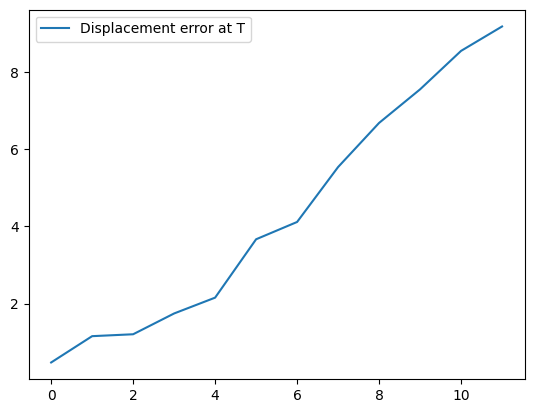

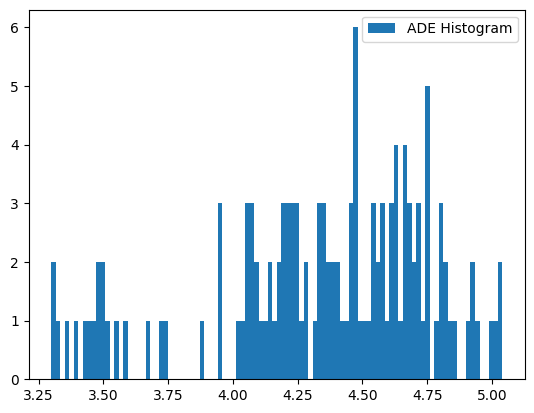

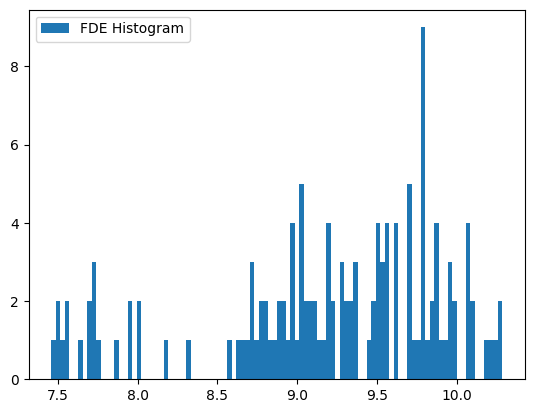

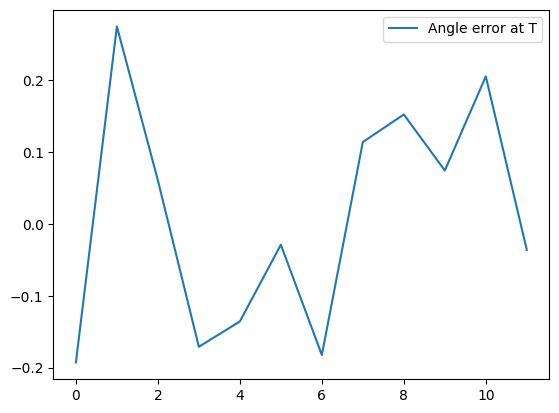

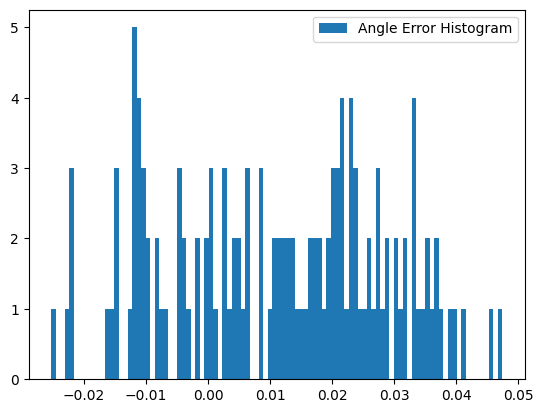

In [12]:
pos_errors = np.linalg.norm(position_preds - position_gts, axis=-1)

# DISPLACEMENT AT T
plt.plot(np.arange(pos_errors.shape[1]), pos_errors.mean(0), label="Displacement error at T")
plt.legend()
plt.show()

# ADE HIST
plt.hist(pos_errors.mean(-1), bins=100, label="ADE Histogram")
plt.legend()
plt.show()

# FDE HIST
plt.hist(pos_errors[:,-1], bins=100, label="FDE Histogram")
plt.legend()
plt.show()

angle_errors = angular_distance(yaw_preds, yaw_gts).squeeze()

# ANGLE ERROR AT T
plt.plot(np.arange(angle_errors.shape[1]), angle_errors.mean(0), label="Angle error at T")
plt.legend()
plt.show()

# ANGLE ERROR HIST
plt.hist(angle_errors.mean(-1), bins=100, label="Angle Error Histogram")
plt.legend()
plt.show()

# Qualitative evaluation

## Visualise results
We can also visualise some images with predicted and annotated trajectories using L5Kit visualisation features.

In this example, we draw 20 images from our dataset and we visualise predicted and annotated trajectories on top of them.

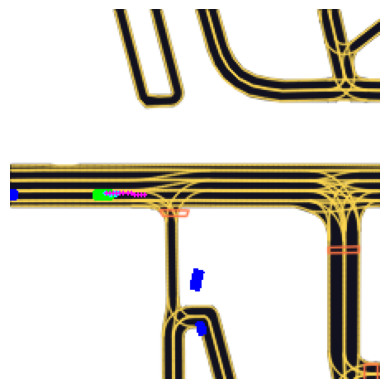

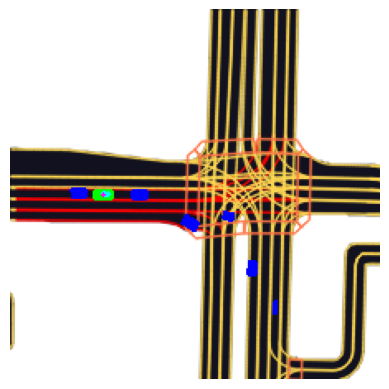

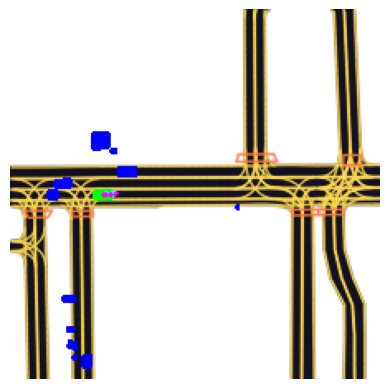

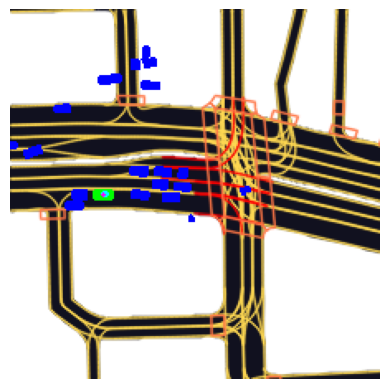

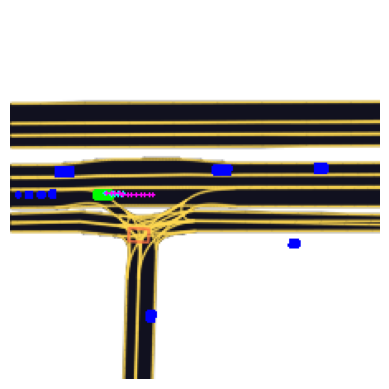

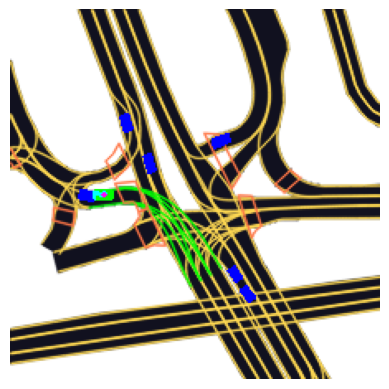

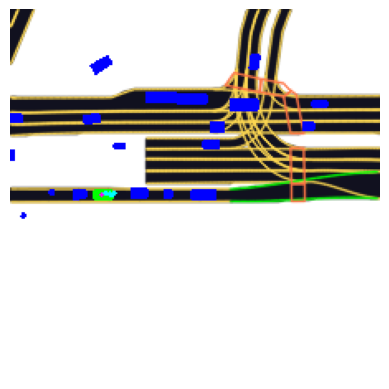

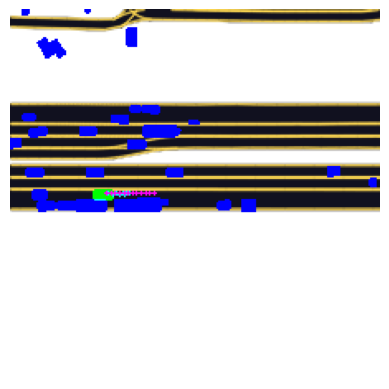

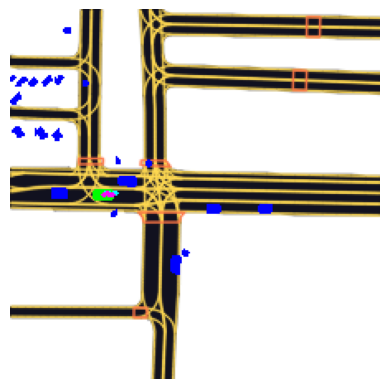

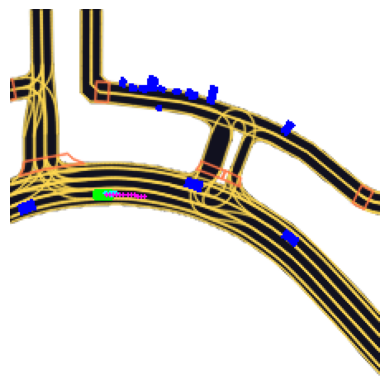

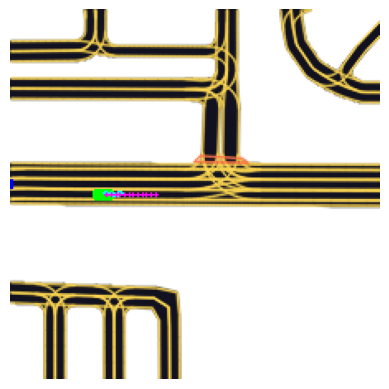

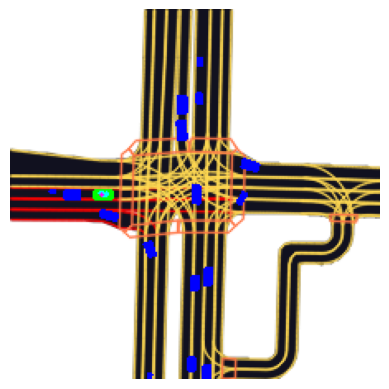

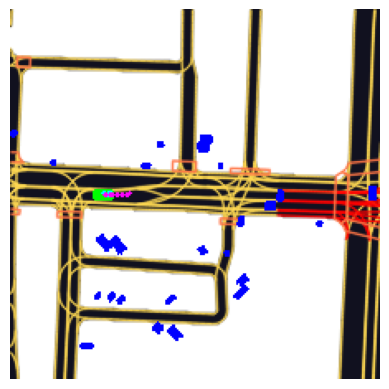

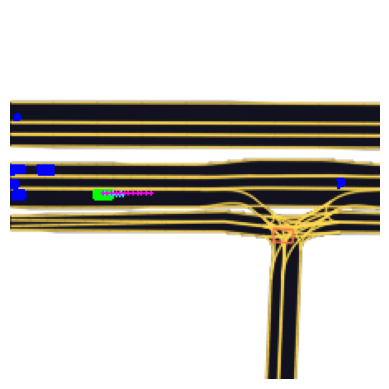

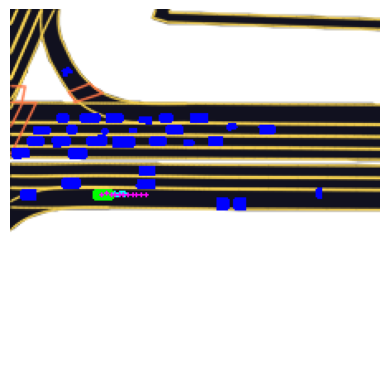

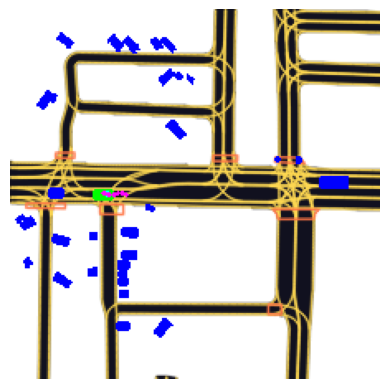

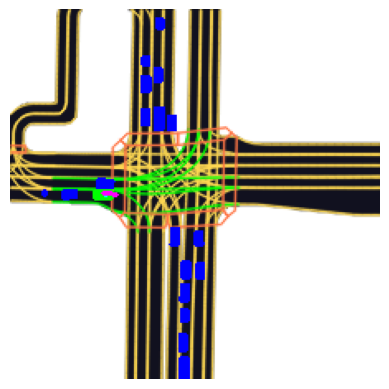

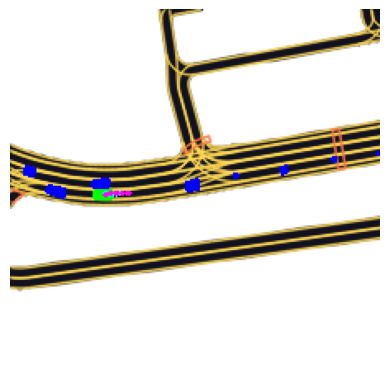

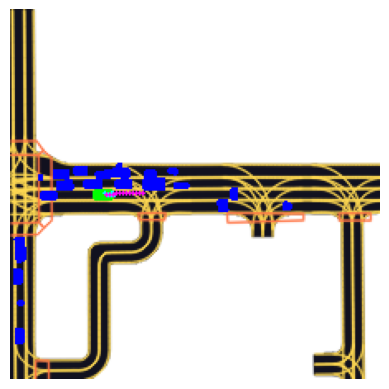

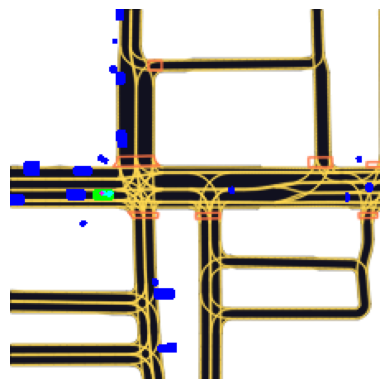

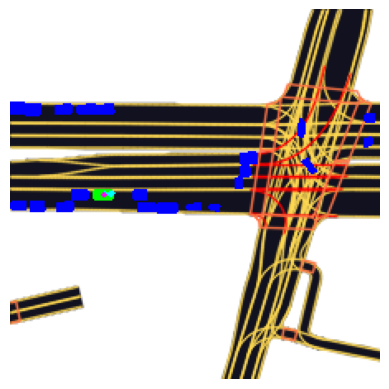

In [13]:
for frame_number in range(0, len(eval_dataset), len(eval_dataset) // 20):
    
    data = eval_dataloader.dataset[frame_number]
    data_batch = default_collate([data])
    if device_name == "mps":
        data_batch = {k: v.float().to(device) for k, v in data_batch.items()}
    else:
        data_batch = {k: v.to(device) for k, v in data_batch.items()}
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    im_ego = rasterizer.to_rgb(data["image"][:-1].transpose(1, 2, 0))
    target_positions = data["target_positions"]
    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(target_positions, data["raster_from_agent"])
    
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.axis("off")
    plt.show()

## Visualise the open-loop

To visualise the open loop we can just repeat the same operations for the consecutive frames.

In this example, we show the first 200 frames for our dataset, plotting predicted and annotated trajectories.

**We want to stress this out again: this is an open loop evaluation, we are NOT controlling the AV with our predictions**

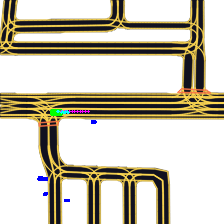

In [14]:
from IPython.display import display, clear_output
import PIL
 
for frame_number in range(200):
    
    data = eval_dataloader.dataset[frame_number]

    data_batch = default_collate([data])
    if device_name == "mps":
        data_batch = {k: v.float().to(device) for k, v in data_batch.items()}
    else:
        data_batch = {k: v.to(device) for k, v in data_batch.items()}
    
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(data["target_positions"], data["raster_from_agent"])
    
    im_ego = rasterizer.to_rgb(data["image"][:-1].transpose(1, 2, 0))
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    clear_output(wait=True)
    display(PIL.Image.fromarray(im_ego))

# Pre-trained model results

We include here the open-loop results of one scene using one of our pre-trained model. The predicted trajectory is well overlapped with the annotated one.

![SegmentLocal](../../docs/images/planning/out_9_open.gif "segment")